In [1]:
# Packages 
%matplotlib notebook
from ipywidgets import *
import pydicom 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob2
import glob
from tkinter import *
import tkinter.filedialog as tkFileDialog

from openpyxl import load_workbook
from openpyxl.worksheet.table import Table
import pandas as pd

#import pymedphys
#import flashgamma

print (" done")



 done


In [2]:
ds_dose = pydicom.read_file('RD.dcm')
ds_plan = pydicom.read_file('RP.dcm')

print('ds_dose',ds_dose)
print('ds_plan', ds_plan)
print('ds_dose.DoseGridScaling', ds_dose.DoseGridScaling,ds_dose['3004', '000e'].value )

ds_dose Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 226
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.2452.6.3742283593.1316652367.3585009831.4109659993
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.250.1.59.3.0.3.5.3
(0002, 0013) Implementation Version Name         SH: 'ETIAM_DCMBP_353'
(0002, 0016) Source Application Entity Title     AE: 'RPRC2_DICOMSRV'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'DOSE']
(0008, 0012) Instance Creation Date              DA: '20201215'
(0008, 0013) Instance Creation Time              TM: '173407'
(0008, 0016)

In [3]:
# ********************** Définition de la fonction Profil dans le sens tète- pieds ****************************************
# Note : y_profil représente la profondeur et z_profil représente la coupe 
def Plot_Profil_2(ds_dose, ds_plan , y_profil, x_profil) : 
    if ds_dose is None or ds_plan is None :
        print ('Error put rtdose and rtplan in this order ')
    else : 
        
        Titre = 'Profil de dose' 
        legende = 'Gy' 
#         Titre = input('saisi le Titre de graphe :' )
#         legende = input('saisi la légende de la courbe 01 :' )
    #def Plot_Rdt(ds_dose, ds_plan , x_Rdt, z_Rdt, num_graphe) : 
        #Coord isocentre à partir de RT_plan converties en mm
        coord_iso_x=ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[0]
        coord_iso_y=ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[1]
        coord_iso_z=ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[2]
        print ('coord_iso_x y z= ',coord_iso_x,coord_iso_y,coord_iso_z)

        # Faire un lien entre le RT dose et RT plan 
        position_image=list(ds_dose['0020','0032'].value) #Orientation du repère comme dans  x augmente à gauche, y en post, z en tête   
        position_image_x=list(ds_dose['0020','0032'].value)[0]
        position_image_y=list(ds_dose['0020','0032'].value)[1]
        position_image_z=list(ds_dose['0020','0032'].value)[2]
        print ('position_image_x y z= ',position_image_x,position_image_y,position_image_z)

        # coupe centrale et point centrale dans la matrice de dose 
        Z_centre = int(ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[2]-int(position_image_z))
        iso_X =int(ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[0]-int(position_image_x))
        iso_Y =int(ds_plan.BeamSequence[0].ControlPointSequence[0].IsocenterPosition[1]-int(position_image_y))
        print ('iso_X y z= ',iso_X,iso_Y,Z_centre)
        
        dim_dose= ds_dose.pixel_array.shape
        print ('dim_dose = ',dim_dose)

        px=pixel_spacing_x=(ds_dose['0028','0030'].value[0]) #definition de la résolution de la matrice de dose
        pixel_spacing_y=(ds_dose['0028','0030'].value[1])
        slice_spacing_z=(ds_dose['3004','000C'].value[1])
        print ('px y z= ',px,pixel_spacing_y,slice_spacing_z)

        coord_iso_dose=(round(iso_X/pixel_spacing_x),round(iso_Y/pixel_spacing_y),round(Z_centre/slice_spacing_z))
        print ('coord_iso_dose = ',coord_iso_dose)
        
        # ------------------- les limites en X et Y et Z -------------
        X_lim = ((-coord_iso_dose[0])*pixel_spacing_x,(dim_dose[2]-coord_iso_dose[0])*pixel_spacing_x)
        print ('X_lim= ',X_lim)
        Y_lim = (0,dim_dose[1]*pixel_spacing_y)
        print ('Y_lim= ',Y_lim)
        Z_lim = ((-coord_iso_dose[2])*slice_spacing_z,(dim_dose[0]-coord_iso_dose[2])*slice_spacing_z)
        print ('Z_lim= ',Z_lim)


        #----------------------------------- Profil------------------------------
        # choix de (y et z en mm )
        #y_profil = 25  # en mm
        coord_y_profil = int(y_profil/pixel_spacing_y)
        #z_profil = 0     # en mm
        #coord_z_profil = int(z_profil/slice_spacing_z + coord_iso_dose[2])
        coord_x_profil = int(x_profil/pixel_spacing_x + coord_iso_dose[0])
        print ('coord_x_profil y= ',coord_x_profil,coord_y_profil)
        
        # la fonction Profil ds_dose.DoseGridScaling est la coef qui faut utiliser pour avoir une dose en Gy
        Max_dose= max(ds_dose.pixel_array[:,coord_y_profil,coord_x_profil])
#        Profil = np.array(ds_dose.pixel_array[:,coord_y_profil,coord_x_profil])/(Max_dose)*100
        Profil = np.array(ds_dose.pixel_array[:,coord_y_profil,coord_x_profil])*ds_dose.DoseGridScaling
        print('dose', ds_dose.DoseGridScaling, Profil, pixel_spacing_x, pixel_spacing_y, slice_spacing_z)
    
        # L'axe horizontal de profil
        z_axis_profil= np.linspace((-coord_iso_dose[2])*slice_spacing_z,(dim_dose[0]-coord_iso_dose[2])*slice_spacing_z,(dim_dose[0]))
        print ('z_axis_profil= ',z_axis_profil)
        
        #fig = plt.figure()
        fig, axs = plt.subplots(1,1)
        #axs[0].plot(y_axis_Rdt,Rdt,color='tab:blue')
        #axs[0].plot(y_axis_Rdt,Rdt_1,color='tab:red')
        axs.set_xlabel('Z (mm)')
        axs.set_ylabel('Dose Gy')
        #axs.set_ylim( ymin=0, ymax=120)
        axs.set_xlim(left=None, right=None, emit=True, auto=False, xmin=-200, xmax=200)
        axs.set_xlim(left=None, right=None, emit=True, auto=False)
        axs.set_title(Titre)
        line_Profil, = axs.plot(z_axis_profil,Profil, color='tab:Blue', label=legende,linestyle="dashed")
        axs.legend(loc="upper left")


print (" done")


 done


coord_iso_x y z=  0.00 -100.99 0.00
position_image_x y z=  -201.986715 -202.360287 -200.000000
iso_X y z=  201 101 200
dim_dose =  (401, 202, 203)
px y z=  2.000000 2.000000 1.00
coord_iso_dose =  (100, 50, 200)
X_lim=  (-200.0, 206.0)
Y_lim=  (0, 404.0)
Z_lim=  (-200.0, 201.0)
coord_x_profil y=  100 50
dose 1.797264e-004 [0.04888558 0.04924503 0.04978421 0.05014367 0.05068284 0.0510423
 0.05158148 0.05212066 0.05248011 0.05301929 0.05355847 0.05391792
 0.0544571  0.05499628 0.05553546 0.05607464 0.05643409 0.05697327
 0.05769217 0.05805163 0.05859081 0.05930971 0.05984889 0.06038807
 0.06110698 0.06164616 0.06218533 0.06290424 0.06362315 0.06416232
 0.06488123 0.06542041 0.06631904 0.06685822 0.06757713 0.06829603
 0.06919466 0.06991357 0.07063248 0.07135138 0.07225001 0.07314864
 0.07386755 0.07476618 0.07566481 0.07656345 0.07746208 0.07836071
 0.07943907 0.0803377  0.08141606 0.08231469 0.08339305 0.08447141
 0.08572949 0.08680785 0.08806594 0.08914429 0.09040238 0.09166046
 0.0929

<IPython.core.display.Javascript object>


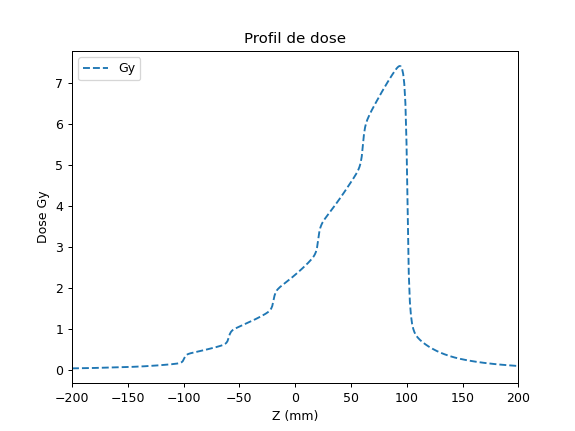

In [4]:
Plot_Profil_2(ds_dose, ds_plan, 100, 0)